AssertionError: 6.339252716211909

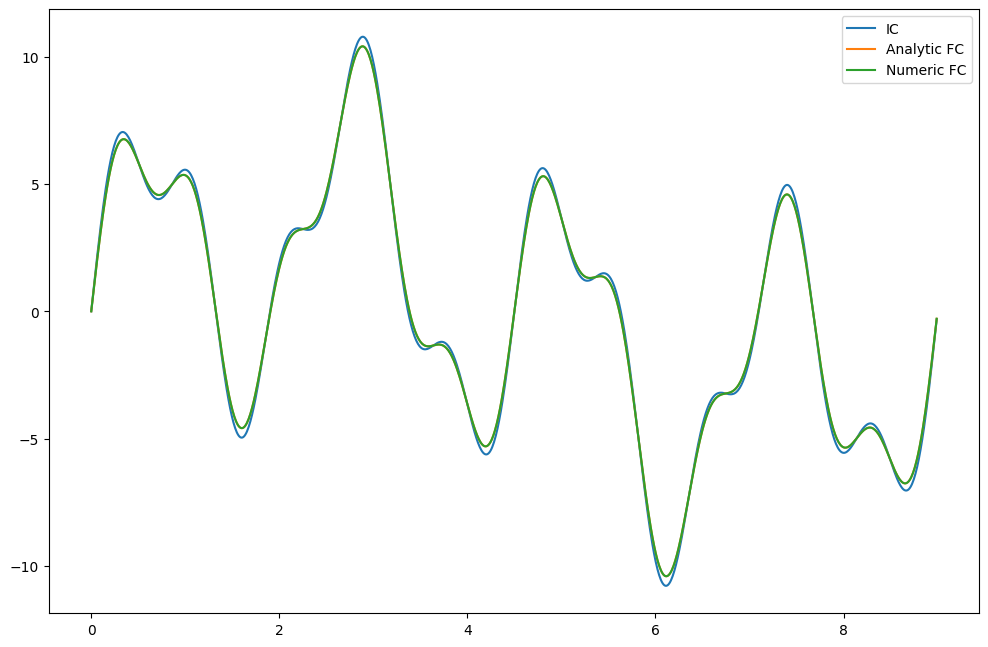

In [65]:
import numpy as np
from matplotlib import pyplot as plt
  
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

def heat_multiplier(N, L, T, alpha=1):
    freqs = np.fft.rfftfreq(N, d=L/N) 
    return np.exp(-alpha * np.pi**2 * T * freqs**2)

def change_basis(u, N):
    return np.fft.rfft(u)/N

def heat(u0, T, N, L=1, alpha=1):
    u0_hat = change_basis(u0, N)
    uT_hat = u0_hat * heat_multiplier(N, L, T, alpha=alpha)
    uT = np.fft.irfft(uT_hat)*N 
    return uT

def coeff2u(coeff, x, L):
    N = x.shape[0]
    freqs = np.fft.rfftfreq(N, d=L/N) 
    return sum(coeff[i]*np.sin(2*np.pi*freqs[i]*x) for i in np.where(coeff)[0])


T = 1e-2
N = 1000
L = 9
alpha = 1
x = np.linspace(0, L, num=N, endpoint=False)
dx = L/N
multiplier = heat_multiplier(N, L, T, alpha=1)


## Initial condition
initial = np.zeros(freqs.shape)
initial[1] = 3.23
initial[4] = 5.67
initial[10] = 2.4
u0 = coeff2u(initial, x, L)

## Numeric solution
uT_num = heat(u0, T, N, L, alpha)

## Analytic
final = initial * multiplier
uT = coeff2u(final, x, L)
    
plt.plot(x, u0, label='IC')
plt.plot(x, uT, label='Analytic FC')
plt.plot(x, uT_num, label='Numeric FC')
plt.legend()
#plt.close()

u0_hat = change_basis(u0, N)
err = np.max(np.abs(uT - uT_num))
assert  err < 1e-9, err

err = np.max(np.abs(u0_hat - initial))
assert  err < 1e-9, err

In [64]:
np.abs(u0_hat - initial).max()

4.2298805164398465e-16

In [23]:
initial.shape

(501,)

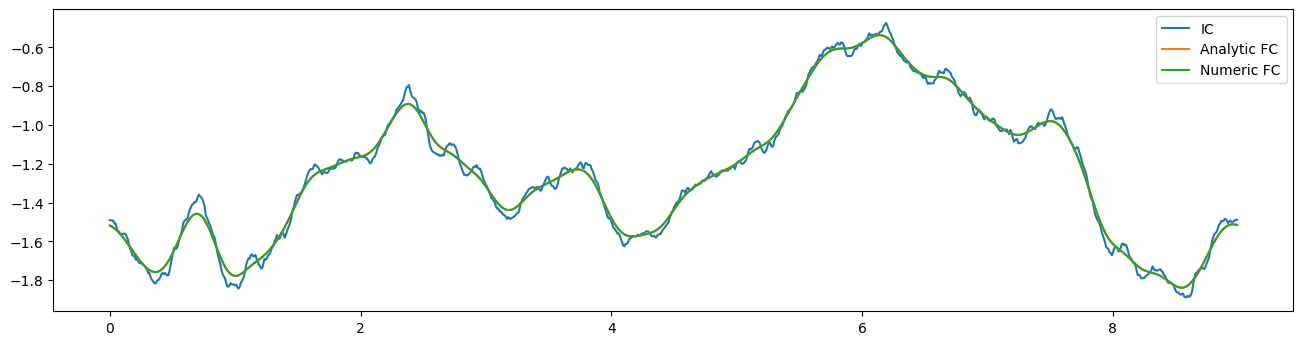

In [52]:
## The complex case. This works, dont touch
import numpy as np
from matplotlib import pyplot as plt
  
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

def heat_multiplier(N, L, T, alpha=1):
    freqs = np.fft.fftfreq(N, d=L/N) 
    return np.exp(-alpha * np.pi**2 * T * freqs**2)

def change_basis(u):
    return np.fft.fft(u)/u.size

def heat(u0, T, L=1, alpha=1):
    N = u0.size
    u0_hat = change_basis(u0)
    uT_hat = u0_hat * heat_multiplier(N, L, T, alpha=alpha)
    uT = np.fft.ifft(uT_hat)*N 
    return uT

def coeff2u(coeff, x, L):
    N = x.shape[0]
    freqs = np.fft.fftfreq(N, d=L/N) 
    return sum(coeff[i]*np.exp(2j*np.pi*freqs[i]*x) for i in np.where(coeff)[0])


T = 1e-2
N = 1000
L = 9
alpha = 1.4
x = np.linspace(0, L, num=N, endpoint=False)
multiplier = heat_multiplier(N, L, T, alpha=alpha)


## Initial condition
initial = np.random.randn(N, 2).view(np.complex128) 
initial = np.squeeze(initial)
initial = initial / (np.arange(N)+1)**1.5  
u0 = coeff2u(initial, x, L)

## Numeric solution
uT_num = heat(u0, T, L, alpha)

## Analytic
final = initial * multiplier
uT = coeff2u(final, x, L)
    
plt.plot(x, u0.imag, label='IC')
plt.plot(x, uT.imag, label='Analytic FC')
plt.plot(x, uT_num.imag, label='Numeric FC')
plt.legend()


u0_hat = change_basis(u0)
err = np.max(np.abs(uT - uT_num))
assert  err < 1e-9, err

err = np.max(np.abs(u0_hat - initial))
assert  err < 1e-9, err